---
### model 4 : Ensemble with XGBoost & LightGBM
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value
all_features = all_data.columns.tolist() # All features

# Add 'number of missing values per data' as a new feature
all_data['num_missing'] = (all_data==-1).sum(axis=1)

# Features excluding nominal feature, features with calc on tag
remaining_features = [col for col in all_features \
                      if ('cat' not in col and 'calc' not in col)] 
# Add num_missin to remaining_features
remaining_features.append('num_missing')

# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_features = [col for col in all_features if 'cat' in col] # Nominal features

# Apply One-Hot encoding
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

# Feature with 'ind' on tag
ind_features = [col for col in all_features if 'ind' in col]

first_col=True
for col in ind_features:
    if first_col:
        all_data['mix_ind'] = all_data[col].astype(str)+'_'
        first_col = False
    else:
        all_data['mix_ind'] += all_data[col].astype(str)+'_'

# Create new feature, the number of eigenvalues for nominal features
cat_count_features = []
for col in cat_features+['mix_ind']:
    val_counts_dic = all_data[col].value_counts().to_dict()
    all_data[f'{col}_count'] = all_data[col].apply(lambda x: val_counts_dic[x])
    cat_count_features.append(f'{col}_count')        

# final datasets
from scipy import sparse

drop_features = ['ps_ind_14', 'ps_ind_10_bin','ps_ind_11_bin', 
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14']

# Data to remove drop_features from remaining_features, cat_count_features
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# Concatenate Data
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

num_train = train.shape[0] # Number of train data 

# Divide train data and test data
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values 

In [2]:
#Evaluation Matrics : 신백균 (https://www.kaggle.com/code/werooring/top-9th-lightgbm-xgboost-ensemble)
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

def eval_gini(y_true, y_pred):
    # Verify that the actual and predicted values are the same size (different values raise errors)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0] # Number of data
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # Diagonal value

    # 1) Gini coefficient for predicted values
    pred_order = y_true[y_pred.argsort()] # Sort y_true values by y_pred size
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # Lorentz Curve
    G_pred = np.sum(L_mid - L_pred) # Gini coefficient for predicted values

    # 2) Gini coefficient when prediction is perfect
    true_order = y_true[y_true.argsort()] # Sort y_true values by y_true size
    L_true = np.cumsum(true_order) / np.sum(true_order) # Lorentz Curve
    G_true = np.sum(L_mid - L_true) #  Gini coefficient when prediction is perfect

    # Normalized Gini coefficient
    return G_pred / G_true 

In [3]:
# Create Stratified K Fold Cross-Verifier
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [5]:
#LightGBM
max_params_lgb = {'bagging_fraction': 0.8043696643500143,
                    'feature_fraction': 0.6829323879981047,
                    'lambda_l1': 0.9264555612104627,
                    'lambda_l2': 0.9774233689434216,
                    'min_child_samples': 10,
                    'min_child_weight': 125.68433948868649,
                    'num_leaves': 28,
                    'objective': 'binary',
                    'learning_rate': 0.01,
                    'bagging_freq': 1,
                    'verbosity': 0,
                    'random_state': 1991}

import lightgbm as lgbm

# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_lgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_lgb = np.zeros(X_test.shape[0]) 

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgbm.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgbm.Dataset(X_valid, y_valid) # lgbm valid dataset

    # Train LightGBM
    lgb_model = lgbm.train(params=max_params_lgb, # Optimal Hyper-parameters
                           train_set=dtrain, # Train data
                           num_boost_round=1500, # Number of boosting iterations
                           valid_sets=dvalid, # Valid data for model performance evaluation
                           feval=gini_lgb, # Evaluation metrics for validation
                           callbacks=[
                             lgbm.early_stopping(stopping_rounds=300),
                             lgbm.log_evaluation(period=100)  #100번째 반복마다 로그 출력
                             ])
    
    # The number of boosting iterations when the model performs best 
    best_iter = lgb_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_lgb += lgb_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.153315	valid_0's gini: 0.270034
[200]	valid_0's binary_logloss: 0.152339	valid_0's gini: 0.280485
[300]	valid_0's binary_logloss: 0.151922	valid_0's gini: 0.286543
[400]	valid_0's binary_logloss: 0.15169	valid_0's gini: 0.291089
[500]	valid_0's binary_logloss: 0.151544	valid_0's gini: 0.294535
[600]	valid_0's binary_logloss: 0.151467	valid_0's gini: 0.296222
[700]	valid_0's binary_logloss: 0.151405	valid_0's gini: 0.297658
[800]	valid_0's binary_logloss: 0.151368	valid_0's gini: 0.298591
[900]	valid_0's binary_logloss: 0.151337	valid_0's gini: 0.299329
[1000]	valid_0's binary_logloss: 0.151325	valid_0's gini: 0.299571
[1100]	valid_0's binary_logloss: 0.151312	valid_0's gini: 0.29987
[1200]	valid_0's binary_logloss: 0.151309	valid_0's gini: 0.299973
[1300]	valid_0's binary_logloss: 0.151309	valid

In [7]:
#XGBoost
max_params_xgb = {'colsample_bytree': 0.8927325521002059,
                    'gamma': 9.766883037651555,
                    'max_depth': 7,
                    'min_child_weight': 6.0577898395058085,
                    'reg_alpha': 8.136089122187865,
                    'reg_lambda': 1.385119327658532,
                    'scale_pos_weight': 1.5142072116395773,
                    'subsample': 0.717425859940308,
                    'objective': 'binary:logistic',
                    'learning_rate': 0.05,
                    'random_state': 1991}

import xgboost as xgb

# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_xgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_xgb = np.zeros(X_test.shape[0]) 

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Create xgboost dmatrix
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    xgb_model = xgb.train(params=max_params_xgb, 
                           dtrain=dtrain,
                           num_boost_round=1000,
                           evals=watchlist,
                           maximize=True,
                           feval=gini_xgb,
                           early_stopping_rounds=150,
                           verbose_eval=100)

    # The number of boosting iterations when the model performs best 
    best_iter = xgb_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_xgb += xgb_model.predict(dtest,
                                            iteration_range=(0, best_iter))/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, 
                                                      iteration_range=(0, best_iter))
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################


c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-logloss:0.21640	train-gini:0.21154	valid-logloss:0.21642	valid-gini:0.20444
[100]	train-logloss:0.15439	train-gini:0.31401	valid-logloss:0.15534	valid-gini:0.28901
[200]	train-logloss:0.15392	train-gini:0.31843	valid-logloss:0.15499	valid-gini:0.29177
[300]	train-logloss:0.15387	train-gini:0.31954	valid-logloss:0.15496	valid-gini:0.29265
[400]	train-logloss:0.15388	train-gini:0.31973	valid-logloss:0.15498	valid-gini:0.29294
[500]	train-logloss:0.15384	train-gini:0.31988	valid-logloss:0.15494	valid-gini:0.29301
[600]	train-logloss:0.15381	train-gini:0.32001	valid-logloss:0.15492	valid-gini:0.29304
[700]	train-logloss:0.15381	train-gini:0.32060	valid-logloss:0.15494	valid-gini:0.29344
[800]	train-logloss:0.15380	train-gini:0.32101	valid-logloss:0.15492	valid-gini:0.29379
[900]	train-logloss:0.15380	train-gini:0.32154	valid-logloss:0.15494	valid-gini:0.29396
[999]	train-logloss:0.15375	train-gini:0.32178	valid-logloss:0.15490	valid-gini:0.29405
Fold 1 gini score: 0.2939556864879

In [8]:
##result : gini score 
print('LightGBM OOF Gini Score:', eval_gini(y, oof_val_preds_lgb))
print('XGBoost OOF Gini Score:', eval_gini(y, oof_val_preds_xgb))

LightGBM OOF Gini Score: 0.2893926116599109
XGBoost OOF Gini Score: 0.2837033867915126


#### Ensemble 
- LightGBM과 XGBoost의 예측 확률값을 가중평균한 값을 최종 예측확률

In [9]:
oof_test_preds = oof_test_preds_lgb * 0.6 + oof_test_preds_xgb * 0.4
print(oof_test_preds)

submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

[0.03265376 0.02918161 0.02971308 ... 0.03999313 0.02618123 0.0345349 ]


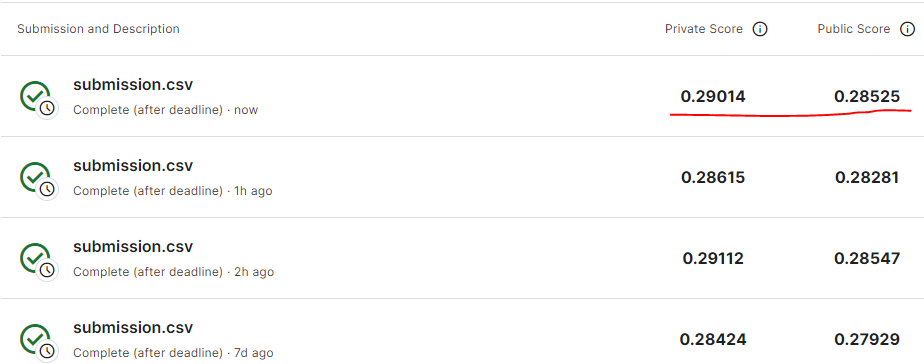

In [11]:
from IPython.display import Image
Image("images/gini_4.PNG")

- 하단부터 차례로 (1) LightGBM Base model, (2) LightGBM with hyperparameter tunning, (3) XGBoost, (4) XGBoost & LightGBM Dnsemble의 결과 